In [427]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle
from scipy.signal import spectrogram
import exoplanet as xo
from scipy import interpolate, signal
import lightkurve as lk

In [428]:
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams["savefig.dpi"] = 200
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 16
plt.rcParams['font.sans-serif'] = ['Arial']

Basat en el tutorial d'espectrogrames d'en David!

# Read the Data

In [429]:
kepler_tref = 2454833
villanova_tref = 2400000 
    
def get_true_eb_values(name):
    #Extracts values from the EB Villanova Catalog
    catalog = pd.read_csv('../catalog_of_EBs_with_SC.csv', sep = ",", index_col = '#KIC')
    
    #Period and t0
    P = catalog.loc[name, 'period']
    t0 = catalog.loc[name, 'bjd0']+villanova_tref-kepler_tref # Time of eclipse. Convention s.t. the primary (deeper) eclipse occurs at phase 0 (BJD-2400000)'
    
    ### In case they become useful in the future:
    #Other Physical Parameters
    R1 = catalog.loc[name, 'radius']
    M1 = catalog.loc[name, 'mass']
    teff = catalog.loc[name, 'teff']
    logg = catalog.loc[name, 'logg']
    feh = catalog.loc[name, 'feh']
    morph = catalog.loc[name, 'morph']
    
    #Light curve parameters
    pdepth = catalog.loc[name, 'pdepth'] #in flux units
    sdepth = catalog.loc[name, 'sdepth'] #in flux units
    pwidth = 2*catalog.loc[name, 'pwidth'] #in Phase units (it seems to be 1/2 the eclipse duration, so that's why we multiply it by 2)
    swidth = 2*catalog.loc[name, 'swidth']
    
    return P, t0, pwidth, swidth

In [430]:
def load_kepler_lc(name):
    #Retrieve all the existing short-cadence photometry on this system.
    data = lk.search_lightcurvefile(
        'KIC%s'%name, 
        cadence = cadence_type,
        mission = 'kepler').download_all()
    print(data)
    lc_data = data.SAP_FLUX.stitch().remove_nans().remove_outliers(sigma = 3.0, sigma_lower = float('inf'))
    tformat = lc_data.time_format
    return lc_data, data, tformat

In [431]:
KIC = 4544587 #4544587 
cadence_type = "short"
lit_period, lit_t0, pwidth, swidth = get_true_eb_values(KIC)
kepler_lc, lcfs, tformat = load_kepler_lc(KIC);

/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


LightCurveFileCollection of 13 objects:
	KIC 4544587 (13 KeplerLightCurveFiles) Quarters: 3,7,7,7,8,8,8,9,9,9,10,10,10



In [432]:
npoints = 40000
x = np.ascontiguousarray(kepler_lc.time[:npoints], dtype=np.float64)
y = np.ascontiguousarray(kepler_lc.flux[:npoints], dtype=np.float64)
yerr = np.ascontiguousarray(kepler_lc.flux_err[:npoints], dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

Text(0.5, 1.0, 'KIC4544587 Phase-Folded Light Curve')

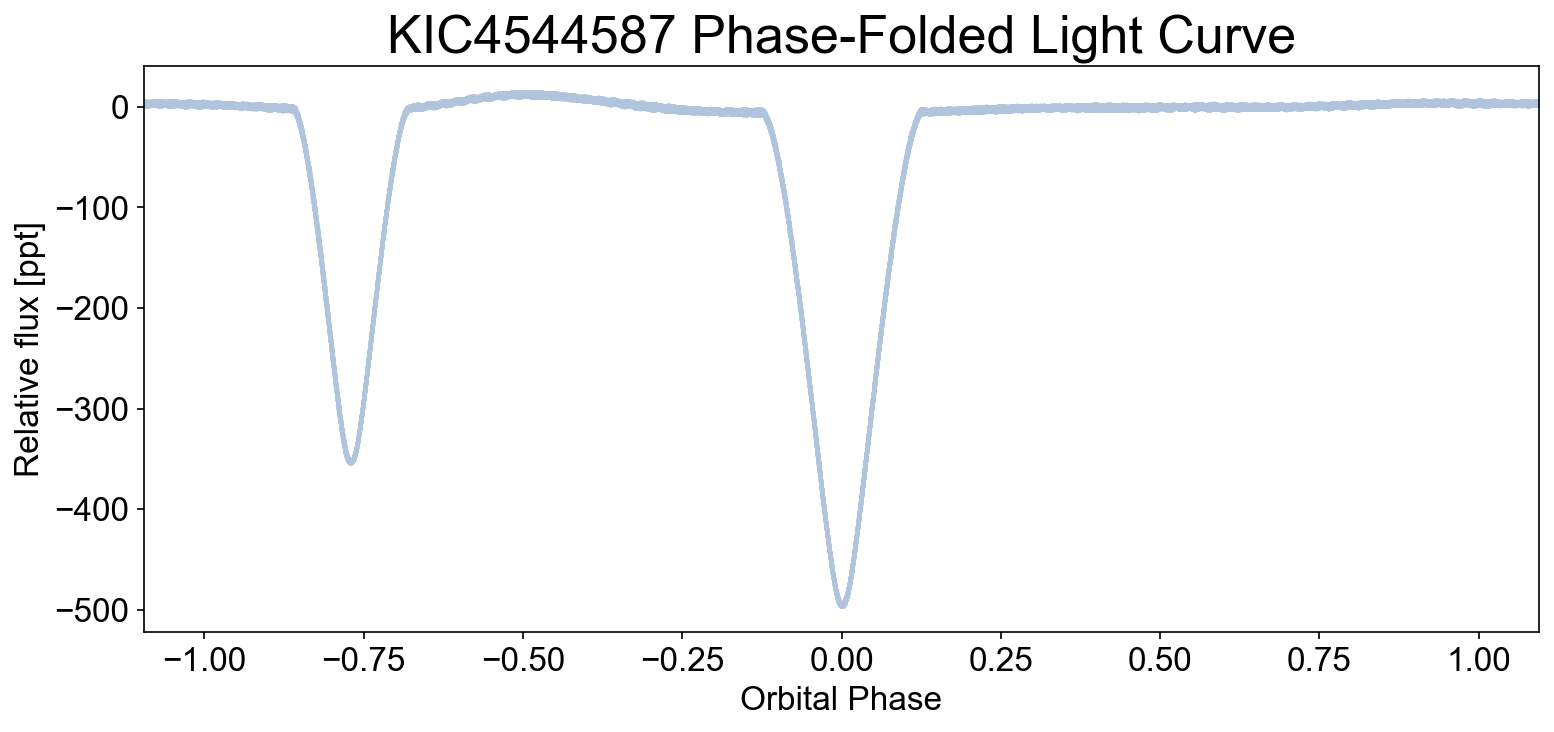

In [433]:
x_fold = (x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period

fig, ax = plt.subplots(1,1)
ax.scatter(x_fold, y,  s=1, c='lightsteelblue')
ax.set(
    xlim = (-0.5 * lit_period, 0.5 * lit_period), 
    xlabel = "Orbital Phase",
    ylabel = "Relative flux [ppt]")
ax.set_title("KIC%s Phase-Folded Light Curve" %KIC, fontsize=25)


Load the frequencies found in the data with our model

In [434]:
osc_data = pd.read_csv("osc_results.txt", sep=" ", header = 0)
osc_data

,freq,power,f_forb,d_to_int,Pgp_Posc_1,Pgp_Posc_2,Pgp_Posc_3
0,3.469707,0.038087,7.595525,0.404475,0.000070,0.000043,0.000047
1,41.370408,0.014178,90.563848,0.436152,0.000040,0.000041,0.000044
2,48.017502,0.012606,105.114985,0.114985,0.000008,0.000015,0.000012
3,3.679982,0.008546,8.055838,0.055838,0.023618,0.001461,0.001321
4,44.848843,0.007636,98.178482,0.178482,0.001222,0.000083,0.000082
5,4.085921,0.006207,8.944478,0.055522,0.014284,0.011116,0.011053
6,2.553934,0.004545,5.590810,0.409190,0.004614,0.004135,0.003595
7,44.306788,0.007882,96.991870,0.008130,3484.248550,0.000045,0.000044
8,3.650675,0.007298,7.991682,0.008318,153.862111,0.000510,0.000507
9,46.193484,0.004755,101.122031,0.122031,6261.790462,0.000119,0.000112


Load the Data (Observed Flux - (Phase Curve + Eclipse Models)

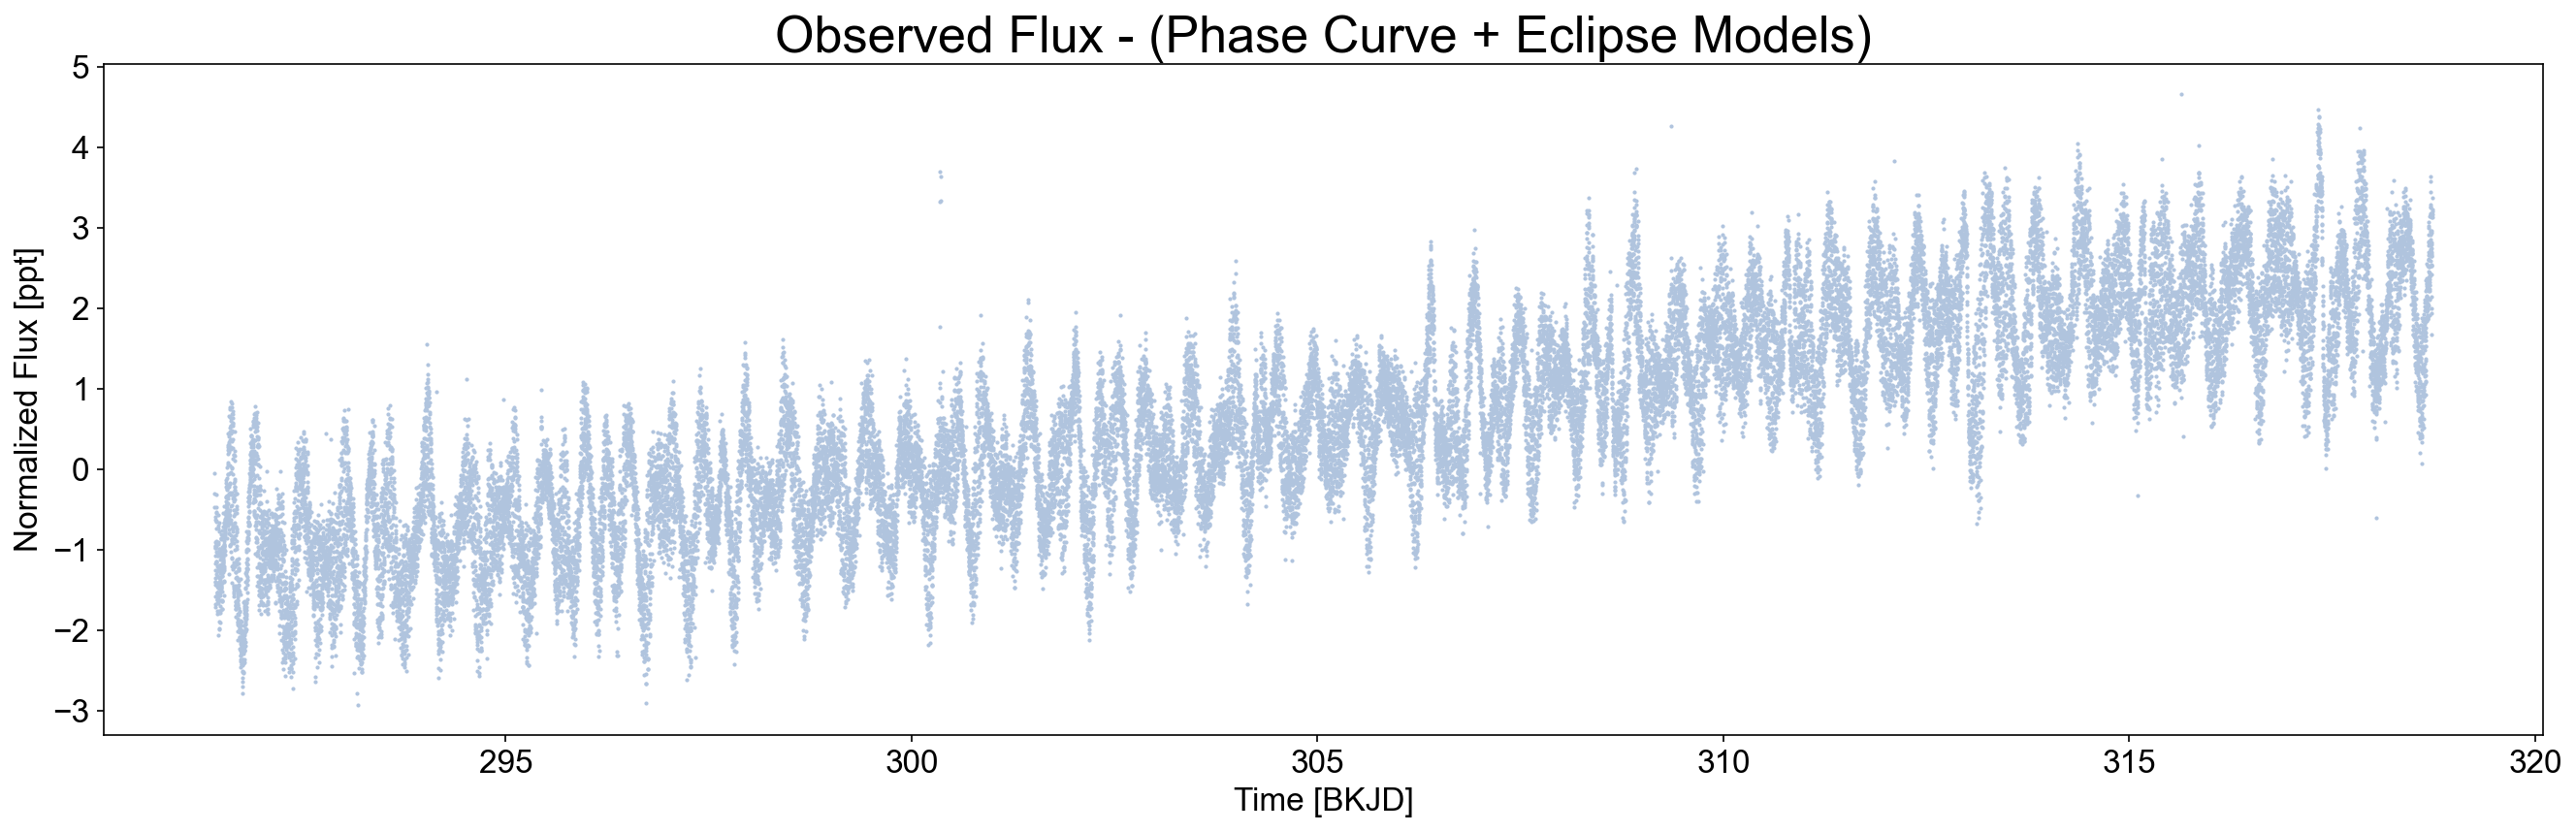

In [579]:
oot = pd.read_csv('osc_and_noise.txt', sep=" ", header=None, names=["Time", "Flux"])
x_oot, y_oot = oot["Time"].values, oot["Flux"].values

fig, ax = plt.subplots(1,1, figsize=(18,6))
ax.scatter(x_oot, y_oot, c="lightsteelblue", s=1)
ax.set(ylabel = "Normalized Flux [ppt]", xlabel = "Time [BKJD]")
ax.set_title("Observed Flux - (Phase Curve + Eclipse Models)", fontsize=25)
fig.tight_layout()
fig.savefig("../figures/tfreq_analysis/data.png")

## Plot the Data and Check if it's Evenly Sampled

In [436]:
#confirm that data is evenly sampled
x_oot_sorted = np.sort(x_oot)
dt_points = (x_oot_sorted[1:] - x_oot_sorted[:-1])

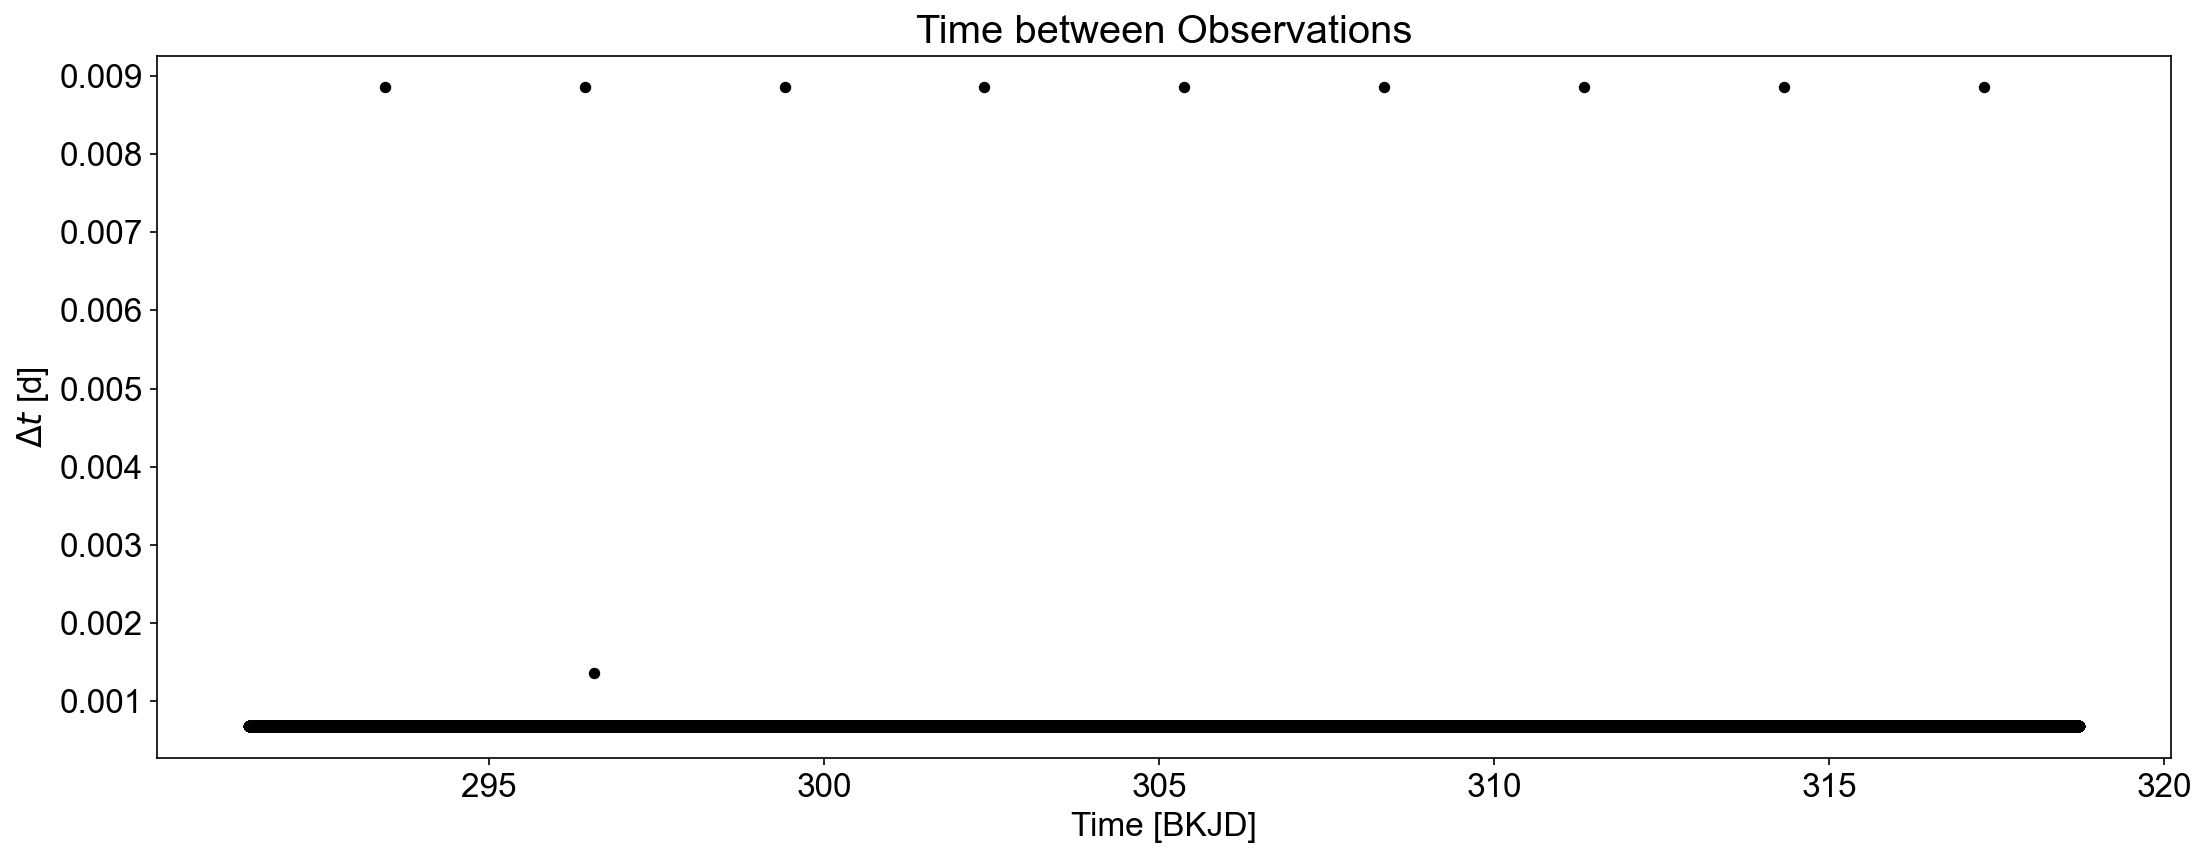

In [437]:
fig, ax = plt.subplots(1,1, figsize=(15,6))

ax.scatter(x_oot_sorted[:-1], dt_points, marker='o', c="k", s=20)
ax.set(xlim=ax.get_xlim(),
            xlabel = "Time [BKJD]",
             ylabel='$\Delta t$ [d]',
             title='Time between Observations');

fig.tight_layout()
fig.savefig("../figures/tfreq_analysis/timsampling.png")

#np.median(delta_t*24*60*60) #todo : fill in the gas
#np.max(delta_t)/np.median(delta_t)

# every time the local value of time is above ~13, add a fake point in between.
#The number of points will depend on the above ratio

In [84]:
kepler_tref = 2454833
villanova_tref = 2400000 
    
def get_true_eb_values(name):
    #Extracts values from the EB Villanova Catalog
    catalog = pd.read_csv('../catalog_of_EBs_with_SC.csv', sep = ",", index_col = '#KIC')
    
    #Period and t0
    P = catalog.loc[name, 'period']
    t0 = catalog.loc[name, 'bjd0']+villanova_tref-kepler_tref # Time of eclipse. Convention s.t. the primary (deeper) eclipse occurs at phase 0 (BJD-2400000)'
    
    ### In case they become useful in the future:
    
    #Other Physical Parameters
    R1 = catalog.loc[name, 'radius']
    M1 = catalog.loc[name, 'mass']
    teff = catalog.loc[name, 'teff']
    logg = catalog.loc[name, 'logg']
    feh = catalog.loc[name, 'feh']
    morph = catalog.loc[name, 'morph']
    
    #Light curve parameters
    pdepth = catalog.loc[name, 'pdepth'] #in flux units
    sdepth = catalog.loc[name, 'sdepth'] #in flux units
    pwidth = 2*catalog.loc[name, 'pwidth'] #in Phase units (it seems to be 1/2 the eclipse duration, so that's why we multiply it by 2)
    swidth = 2*catalog.loc[name, 'swidth']
    
    return P, t0

In [85]:
KIC = 4544587 #https://arxiv.org/pdf/1306.1819.pdf
lit_period, lit_t0 = get_true_eb_values(KIC)

print("Orbital Period = %0.02f d" %lit_period)
print("Time of Eclipse = %0.02f d" %lit_t0)

Orbital Period = 2.19 d
Time of Eclipse = 121.14 d


# Frequency Analysis

## Calculate Sampling Properties

In [86]:
Nt = x_oot.shape[0] # Number of observations/samples in the time domain
dt = np.median(np.diff(x_oot)) # [d] # Time span between consecutive samples
fs = 1.0/dt # Sampling frequency [1/d]
fmax = fs/2. #f_nyquist = fs/2
total_duration = x_oot.shape[0]/fs #total duration of data

Nt*dt, total_duration

print("Number of samples in the time domain = %i" %Nt)
print("Timespan between consecutive samples = %0.06f (d)" %dt) # [d] This should ~ as Kepler SC sampling (58sec)
print("Sampling frequency = %0.02f (d^-1)" %fs)
print("Total duration of Time Array = %0.02f (d)" %total_duration)

Number of samples in the time domain = 40000
Timespan between consecutive samples = 0.000681 (d)
Sampling frequency = 1468.28 (d^-1)
Total duration of Time Array = 27.24 (d)


In [87]:
T = (Nt - 1) / fs #duration of the signal
print("The duration of the signal is %0.02f [d], which will result in \
an effective frequency resolution of %0.02f [d^-1]." %(T, 1/T))

The duration of the signal is 27.24 [d], which will result in an effective frequency resolution of 0.04 [d^-1].


## Create Frequency Grid

In [88]:
orbital_frequency = 1/lit_period
minfr = 5*orbital_frequency #[d^-1] or 1/(total_duration)
maxfr = 200 # 200 #[d^-1]

In [89]:
N_samples_per_peak = 10
df = 1/(total_duration*N_samples_per_peak)
grid_resolution = (maxfr-minfr)/df+1
freq_grid = np.linspace(minfr, maxfr, int(grid_resolution))

In [90]:
print("Nº of samples per peak = %i" %N_samples_per_peak)
print("Delta frequency btw Observations (using %i samples per peak) = %0.08f d^-1"%(N_samples_per_peak, df))
print("Delta frequency btw Observations in our Frequency Grid = %0.08f d^-1"%(freq_grid[1]-freq_grid[0]))
print("Nº of Frequency Points (using a delta frequency of %0.08f d^-1) = %i" %(df, grid_resolution))
#Compare with Old Version
df_3E5 = (maxfr-minfr)/(30000-1)
print("## Nº of Samples if we used 30.000 frequency points = %0.02f" %(1/(total_duration*df_3E5))) #number of samples per peak if we used grid_resolution = 30000 (as in old version)

Nº of samples per peak = 10
Delta frequency btw Observations (using 10 samples per peak) = 0.00367071 d^-1
Delta frequency btw Observations in our Frequency Grid = 0.00367072 d^-1
Nº of Frequency Points (using a delta frequency of 0.00367071 d^-1) = 53864
## Nº of Samples if we used 30.000 frequency points = 5.57


## Generate LS Periodogram

In [91]:
def ls_estimator(time, flux, frequencies, npeaks_pg):
    #Function based on Dan's LS estimator code but adjusted for a variable frequency grid
    #(https://github.com/exoplanet-dev/exoplanet/blob/main/src/exoplanet/estimators.py)
    periods = 1./frequencies
    model = LombScargle(time, flux)
    powers = model.power(frequencies, method="fast", normalization="psd")
    powers /= len(time)
    power_est = np.array(powers)
    # Identify Peaks 
    peaks = xo.find_peaks(frequencies, powers, max_peaks=npeaks_pg)
    return dict(periodogram=(frequencies, power_est), peaks=peaks, ls=model)

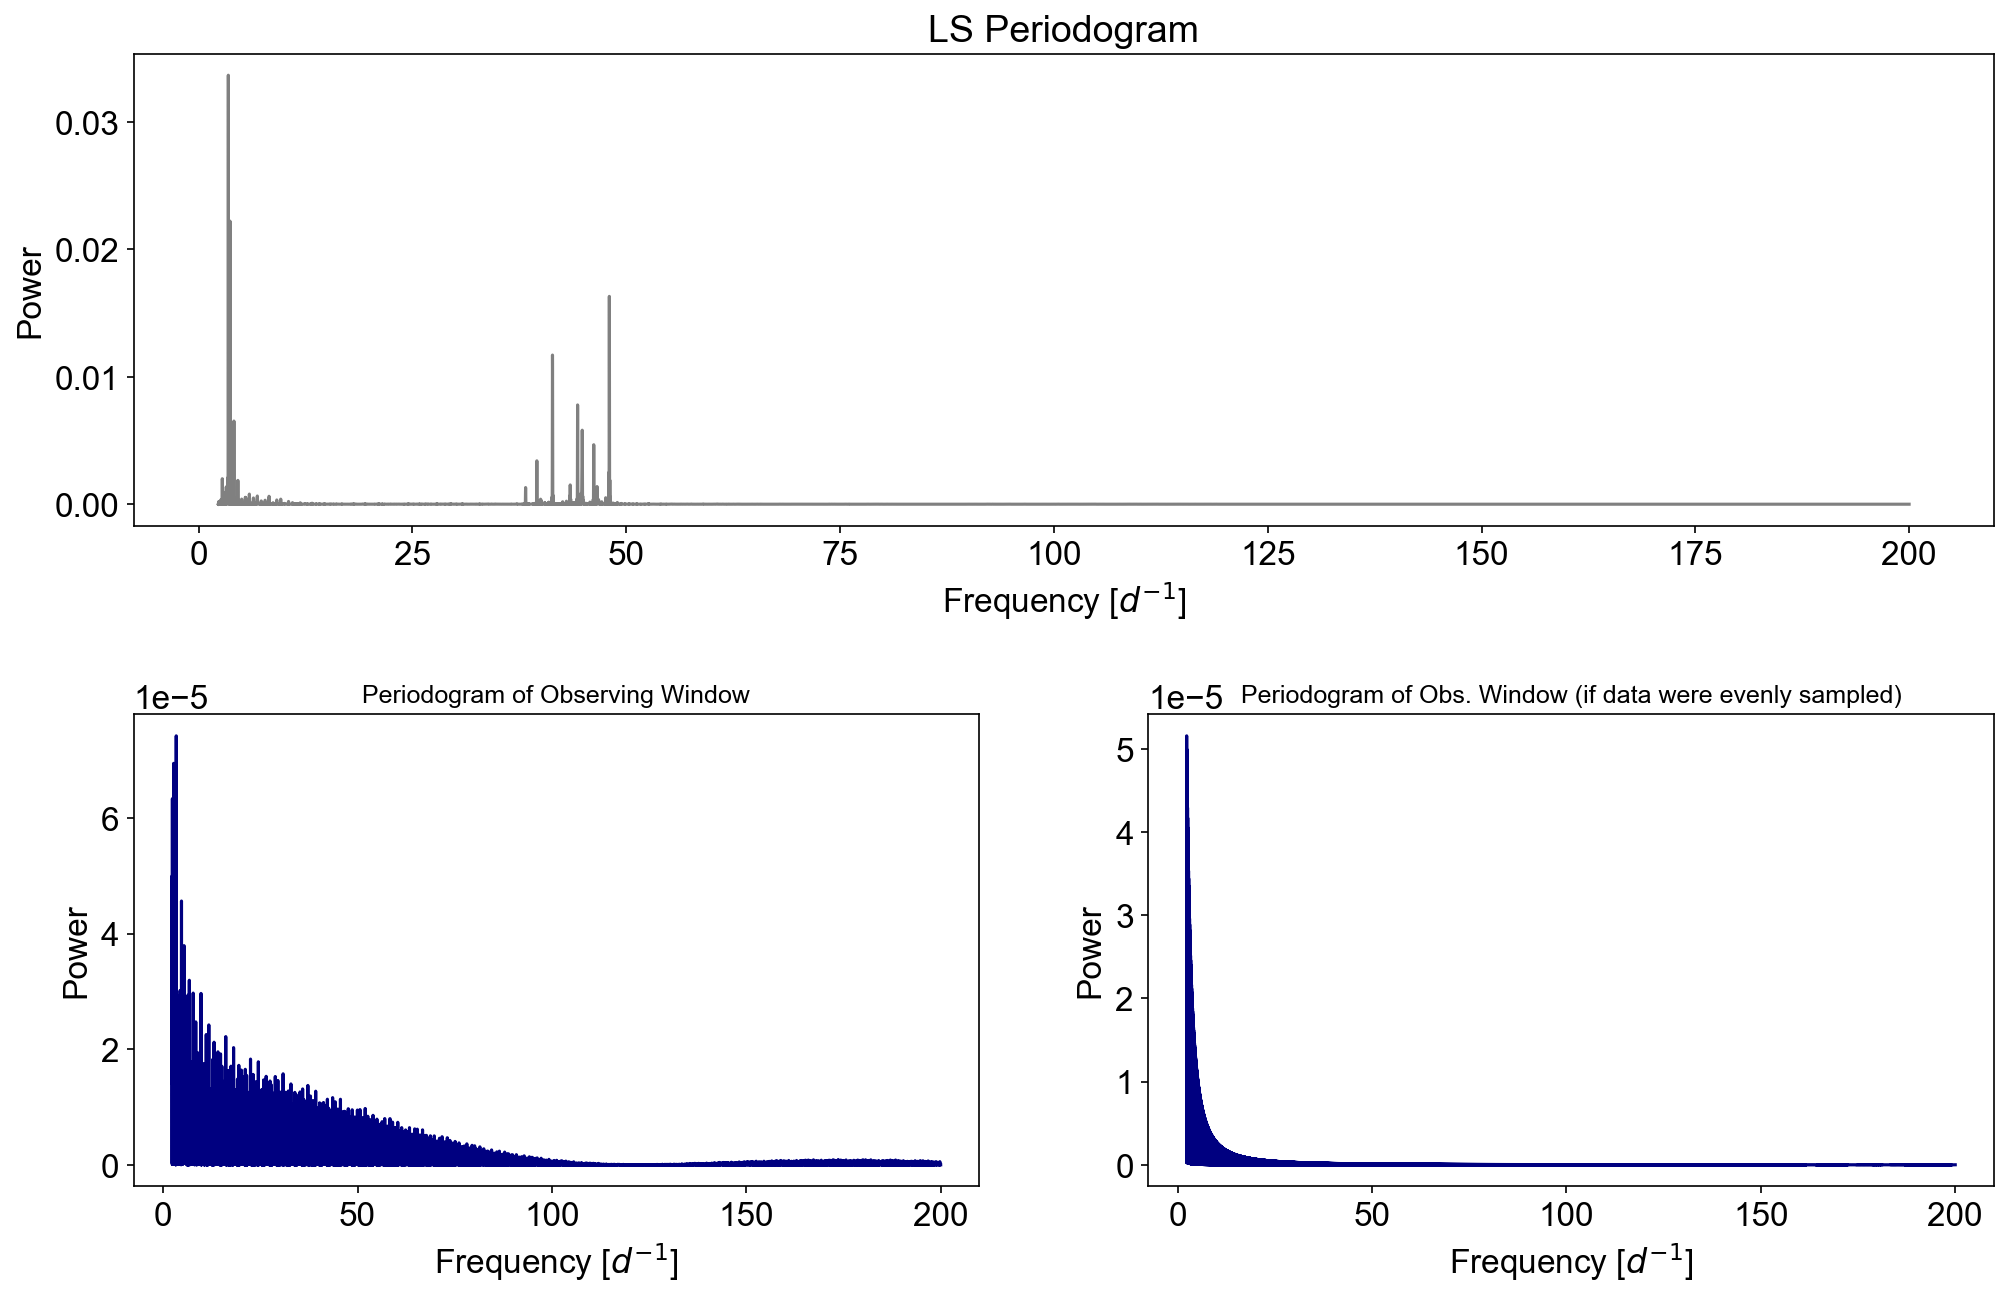

In [92]:
npeaks_periodogram = 15
ls_oot = ls_estimator(x_oot, y_oot, freq_grid, npeaks_periodogram)

fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
ax1 = fig.add_subplot(211) 
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

ax1.plot(ls_oot["periodogram"][0], ls_oot["periodogram"][1], c="grey")
ax1.set(xlabel = r"Frequency [$d^{-1}$]", ylabel = "Power") 
ax1.set_title("LS Periodogram", fontsize=18)

ls_window = LombScargle(x_oot, 1.0, fit_mean = False, center_data=False)
p_window = ls_window.power(freq_grid)
ax2.plot(freq_grid, p_window, c="navy")
ax2.set(xlabel = r"Frequency [$d^{-1}$]", ylabel = "Power")
ax2.set_title("Periodogram of Observing Window", fontsize=12);

x_dt = np.arange(0,total_duration,dt)
ls_window = LombScargle(x_dt, 1.0, fit_mean = False, center_data=False)
p_window = ls_window.power(freq_grid)
ax3.plot(freq_grid, p_window, c="navy")
ax3.set(xlabel = r"Frequency [$d^{-1}$]", ylabel = "Power")
ax3.set_title("Periodogram of Obs. Window (if data were evenly sampled)", fontsize=12);

## Create Spectrogram of Unevenly Sampled Data

The following is an implementation of a spectrogram that can deal with unevently sampled data. It uses the extended Lomb-Scargle periodogram. 

First, define your window. This is a nice page explaining some of the fundamental ones: https://community.sw.siemens.com/s/article/window-types-hanning-flattop-uniform-tukey-and-exponential

In [504]:
alpha = 0.25 #0.25 for a Tukey window: "Shape parameter of the Tukey window, representing the fraction of the window inside the cosine tapered region. If zero, the Tukey window is equivalent to a rectangular window. If one, the Tukey window is equivalent to a Hann window.""
window = ('tukey', alpha) #  If "tukey": Window equal to the equispaced spectrogram default
Nwindow = 1001 # Number of sample points to interpolate from the window
detrend = 'constant' # Detrend parameter equal to the equispaced spectrogram default

Note on windows: Windows are used to "stretch" the frequency peaks. With spectrograms, one tries to overlap them so that each measurement is taken into account with the same weight as every other measurement.

Notes on `dt2`: 

* Too high time resolution (low  Δ𝑡2 ) will result in fuzziness along the frequency direction
* Too low time resolution (high  Δ𝑡2 ) will result in the inability to capture frequencies changing too fast over time
* A trade off time resolution will give a well focused spectrogram with able to detect frequencies that change over tim

In [566]:
dt2 = 0.1305 #0.16 # Desired time resolution 
overlap = alpha/2 #(alpha/2 = overlap set to 1/8)
overlap

0.125

Compute the maximum number of samples per chunk for a given `overlap`, as well as the time resolution of each segment.

In [567]:
Nt_chunk = dt2 / dt / (1 - overlap) # maximum number of samples per segment with an overlap equal to "overlap", if dt2 is to be respected
print(Nt_chunk)
Nt_chunk = max(int(2**np.floor(np.log2(Nt_chunk))), 2) # closer power of two below maximum. note: FFTs work best when N is a power of 2 (see below)

print("Number of samples per chunk: {:d}".format(Nt_chunk))
print("This will give a time resolution of {:g} d (desired {:g} d)".format((Nt_chunk - Nt_chunk//8)*dt, dt2))

218.9838168500448
Number of samples per chunk: 128
This will give a time resolution of 0.0762796 d (desired 0.1305 d)


Calculate duration of each segment and the segment's effective frequency resolution 

In [568]:
Tseg = dt * (Nt_chunk - 1) # Duration of one chunk (= duration of one window)
print("Each chunk will then last {:g} d".format(Tseg))
print("This will result in an effective frequency resolution of {:g} d^-1".format(1/Tseg))

Each chunk will then last 0.0864956 d
This will result in an effective frequency resolution of 11.5613 d^-1


Create time array for the spectrogram. The variable `t2`is the center of each window. Therefore, it goes from where the first time measurement is plus T_seg/2 (half a window), to where the last time measurement is minus the region that is overlapped.  

In [569]:
t2 = np.arange(x_oot[0]+Tseg/2, x_oot[-1]-Tseg/2, Tseg*(1-overlap))
t_seg_start = t2 - Tseg/2
t_seg_end = t2 + Tseg/2

In [570]:
df2 = 1/(Tseg*N_samples_per_peak)
grid_resolution_spectrogram = (maxfr-minfr)/df2+1
f2 = np.linspace(minfr, maxfr, int(grid_resolution_spectrogram))

Prepare window to apply

In [571]:
window_data = signal.get_window(window, Nwindow)
window_t = np.arange(0, Nwindow) * Tseg/(Nwindow - 1)
get_window_value = interpolate.interp1d(window_t, window_data)
apply_window = lambda t, x: x*get_window_value(t)

In [572]:
P = np.zeros((f2.size, t2.size))
print(t2.size, f2.size)

360 172


(Note: The LS Periodogram is *only* equivalent to the (N)FFT periodogram (i.e. |fft|^2) IF the measurements are evenly sampled in time (otherwise, it is similar but NOT the same). In other words, the P_ls is not exactly P_fft = |fft|^2 if the data are unevenly sampled, but it's pretty close. See VanderPlas paper for more details. 
 
In short, for unevenly sampled data, the LS periodogram is an approximation. We'd have to use the NFFT (but it's much slower). 

In [573]:
for i in range(t2.size):
    t_seg_flag = np.logical_and(x_oot >= t_seg_start[i], x_oot < t_seg_end[i])
    ind_seg = np.flatnonzero(t_seg_flag)
    
    if ind_seg.size < 2:
        # No data in this segment, skip
        P[:,i] = np.nan
        continue
    t_seg = x_oot[ind_seg] - t_seg_start[i]
    y_seg = y_oot[ind_seg]

    # Detrend
    y_seg = signal.detrend(y_seg, type="linear")

    # Window
    y_seg = apply_window(t_seg, y_seg) #Apply the given window to the given array along the given axis.

    # Lomb Scargle
    ls = LombScargle(t_seg, y_seg, normalization='psd')
    p = ls.power(f2)

    P[:,i] = p

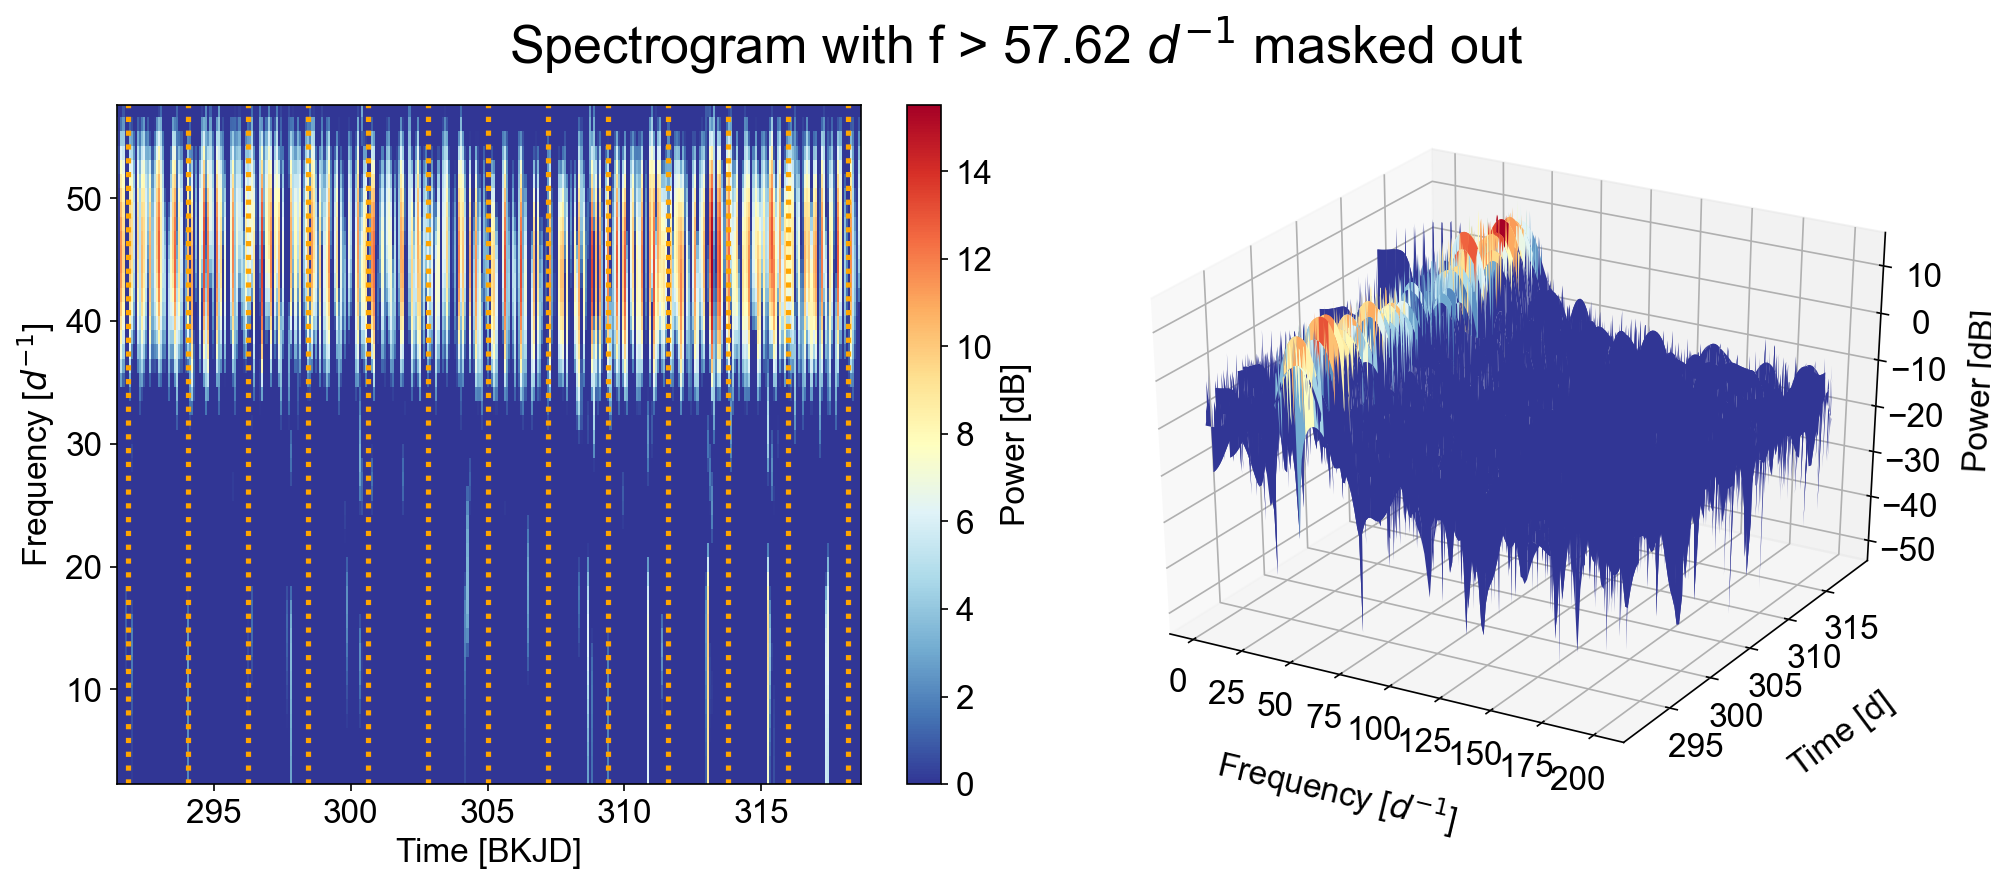

In [574]:
fmin = min(freq_grid)
fmax = 1.2*max(osc_data["freq"])
pmin = 0.0
color_map = "RdYlBu_r"
'''
freq_mask = np.where((f2 >= fmin) & (f2 <= fmax))
# keep only frequencies of interest
f2 = f2[freq_mask]
P = P[freq_mask,:][0]
print("We'll now plot the spectrogram with frequencies ranging from [%0.02f, %0.02f] d^-1" %(fmin, fmax))
'''

fig = plt.figure(figsize=(16,6))
fig.subplots_adjust(wspace=0.0)
fig.suptitle("Spectrogram with f > %0.02f $d^{-1}$ masked out" %fmax, fontsize=25)

ax1 = fig.add_subplot(121) 
ax2 = fig.add_subplot(122, projection='3d')

s = ax1.pcolormesh(t2, f2, 10*np.log10(P), vmin=pmin,  cmap=color_map) #"RdYlBu_r")
ax1.set(ylabel = r'Frequency [$d^{-1}$]', xlabel = 'Time [BKJD]', ylim=(min(freq_grid),fmax))
fig.colorbar(s, ax=ax1, label = "Power [dB]")

s2 = ax2.plot_surface(f2[:, None], t2[None, :], 10*np.log10(P), vmin=pmin, cmap=color_map);
ax2.set_xlabel(r"Frequency [$d^{-1}$]",labelpad = 20)
ax2.set_ylabel("Time [d]",labelpad = 20);
ax2.set_zlabel("Power [dB]",labelpad = 10);

n = np.arange(70,100,1)
transits = lit_t0+n*lit_period
for t in transits:
    if t>=min(x_oot) and t<=max(x_oot):
        ax1.axvline(t, c="orange", lw=2.5, ls=":")
        
fig.savefig("../figures/tfreq_analysis/spectrogram_3d.png")

In [575]:
np.shape(P)

(172, 360)

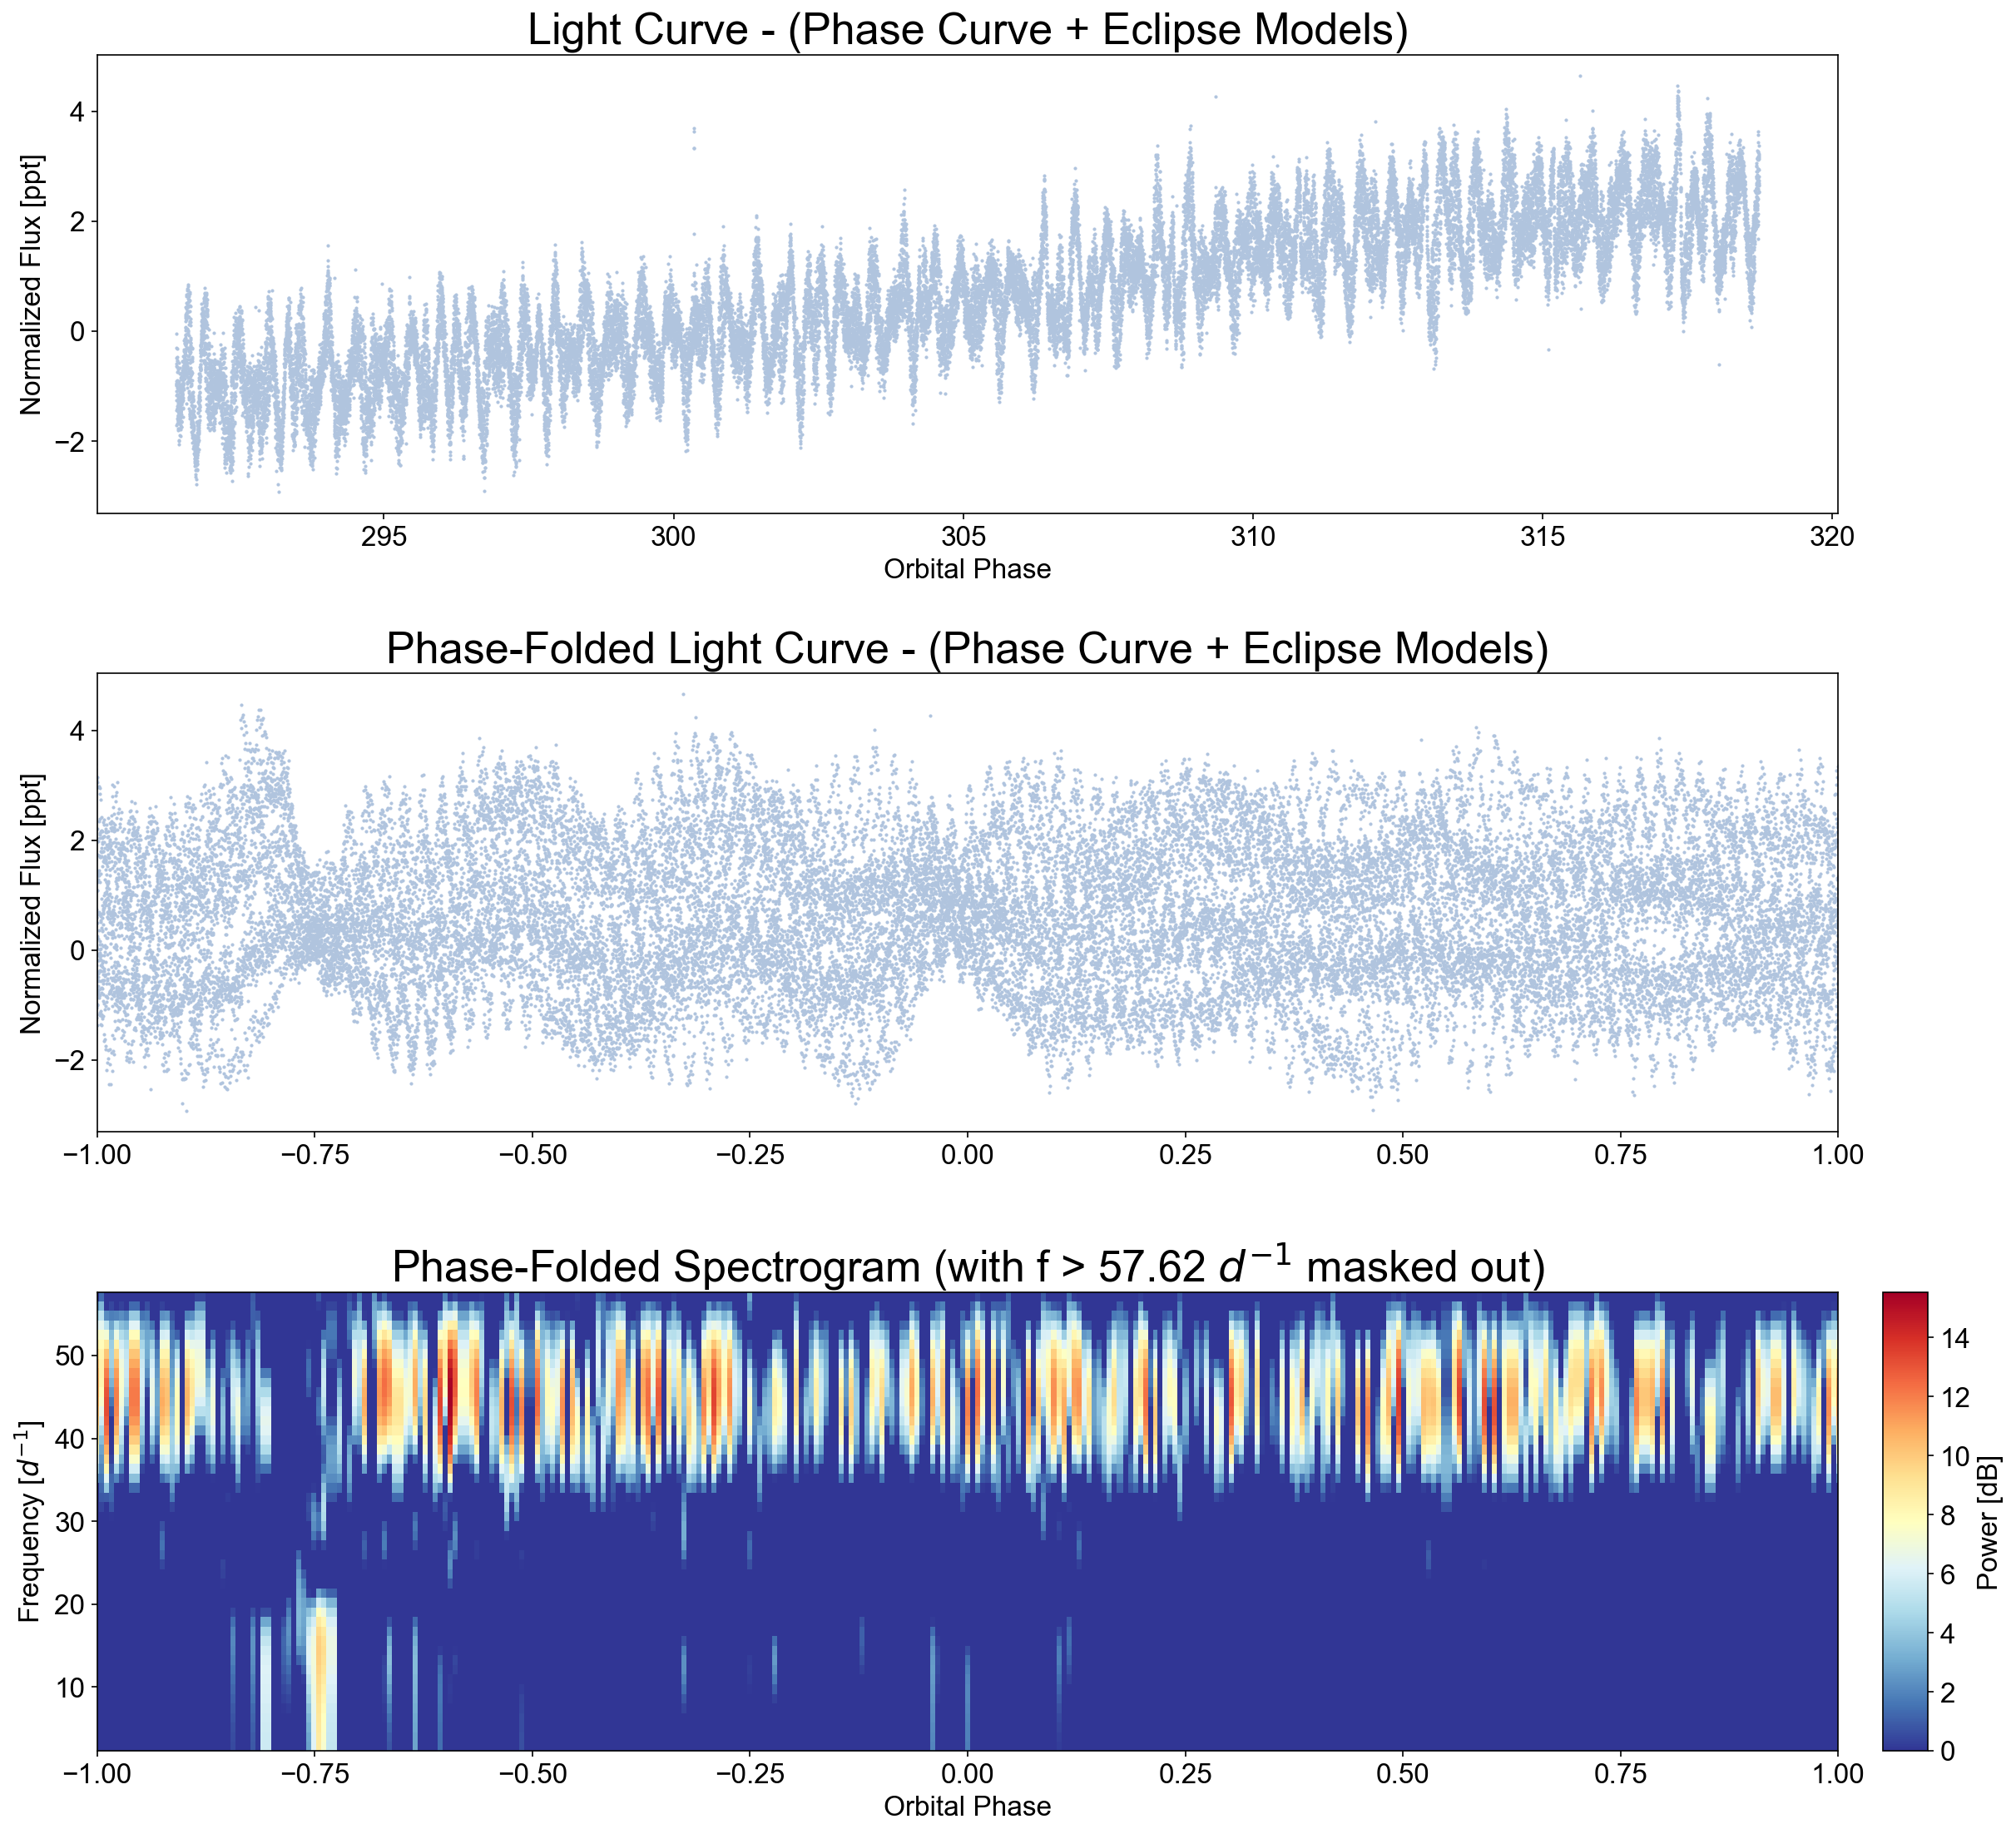

In [586]:
x_oot_fold = (x_oot - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
x2_fold = (t2 - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period

x_oot_order = np.argsort(x_oot_fold)
order2 = np.argsort(x2_fold)

fig = plt.figure(figsize=(18,18))
fig.subplots_adjust(wspace=0.2, hspace=0.35)

#ax1 = fig.add_subplot(121) 
ax1 = fig.add_subplot(311) 
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
#ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(x_oot, y_oot, s=1, c='lightsteelblue')
ax1.set_title("Light Curve - (Phase Curve + Eclipse Models)", fontsize=25)
ax1.set_xlabel("Time [BKJD]")
ax1.set_ylabel("Normalized Flux [ppt]")

ax2.scatter(xoot_fold[x_oot_order], y_oot[x_oot_order], s=1, c='lightsteelblue')
ax2.set_title("Phase-Folded Light Curve - (Phase Curve + Eclipse Models)", fontsize=25)
ax2.set_xlim(-1.0, 1.0)
ax1.set_xlabel("Orbital Phase")
ax2.set_ylabel("Normalized Flux [ppt]")

s = ax3.pcolormesh(x2_fold[order2], f2, 10*np.log10(P[:,order2]), vmin=pmin,  cmap=color_map) #"RdYlBu_r")
ax3.set(ylabel = r'Frequency [$d^{-1}$]', xlabel = 'Orbital Phase', ylim=(min(freq_grid),fmax))
ax3.set_xlim(-1.0, 1.0)
ax3.set_title("Phase-Folded Spectrogram (with f > %0.02f $d^{-1}$ masked out)" %fmax, fontsize=25)

# Add the colorbar outside...
box = ax3.get_position()
pad, width = 0.02, 0.02
cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])
fig.colorbar(s, cax=cax,label = "Power [dB]")

fig.savefig("../figures/tfreq_analysis/phase_folded_spectrogram.png")

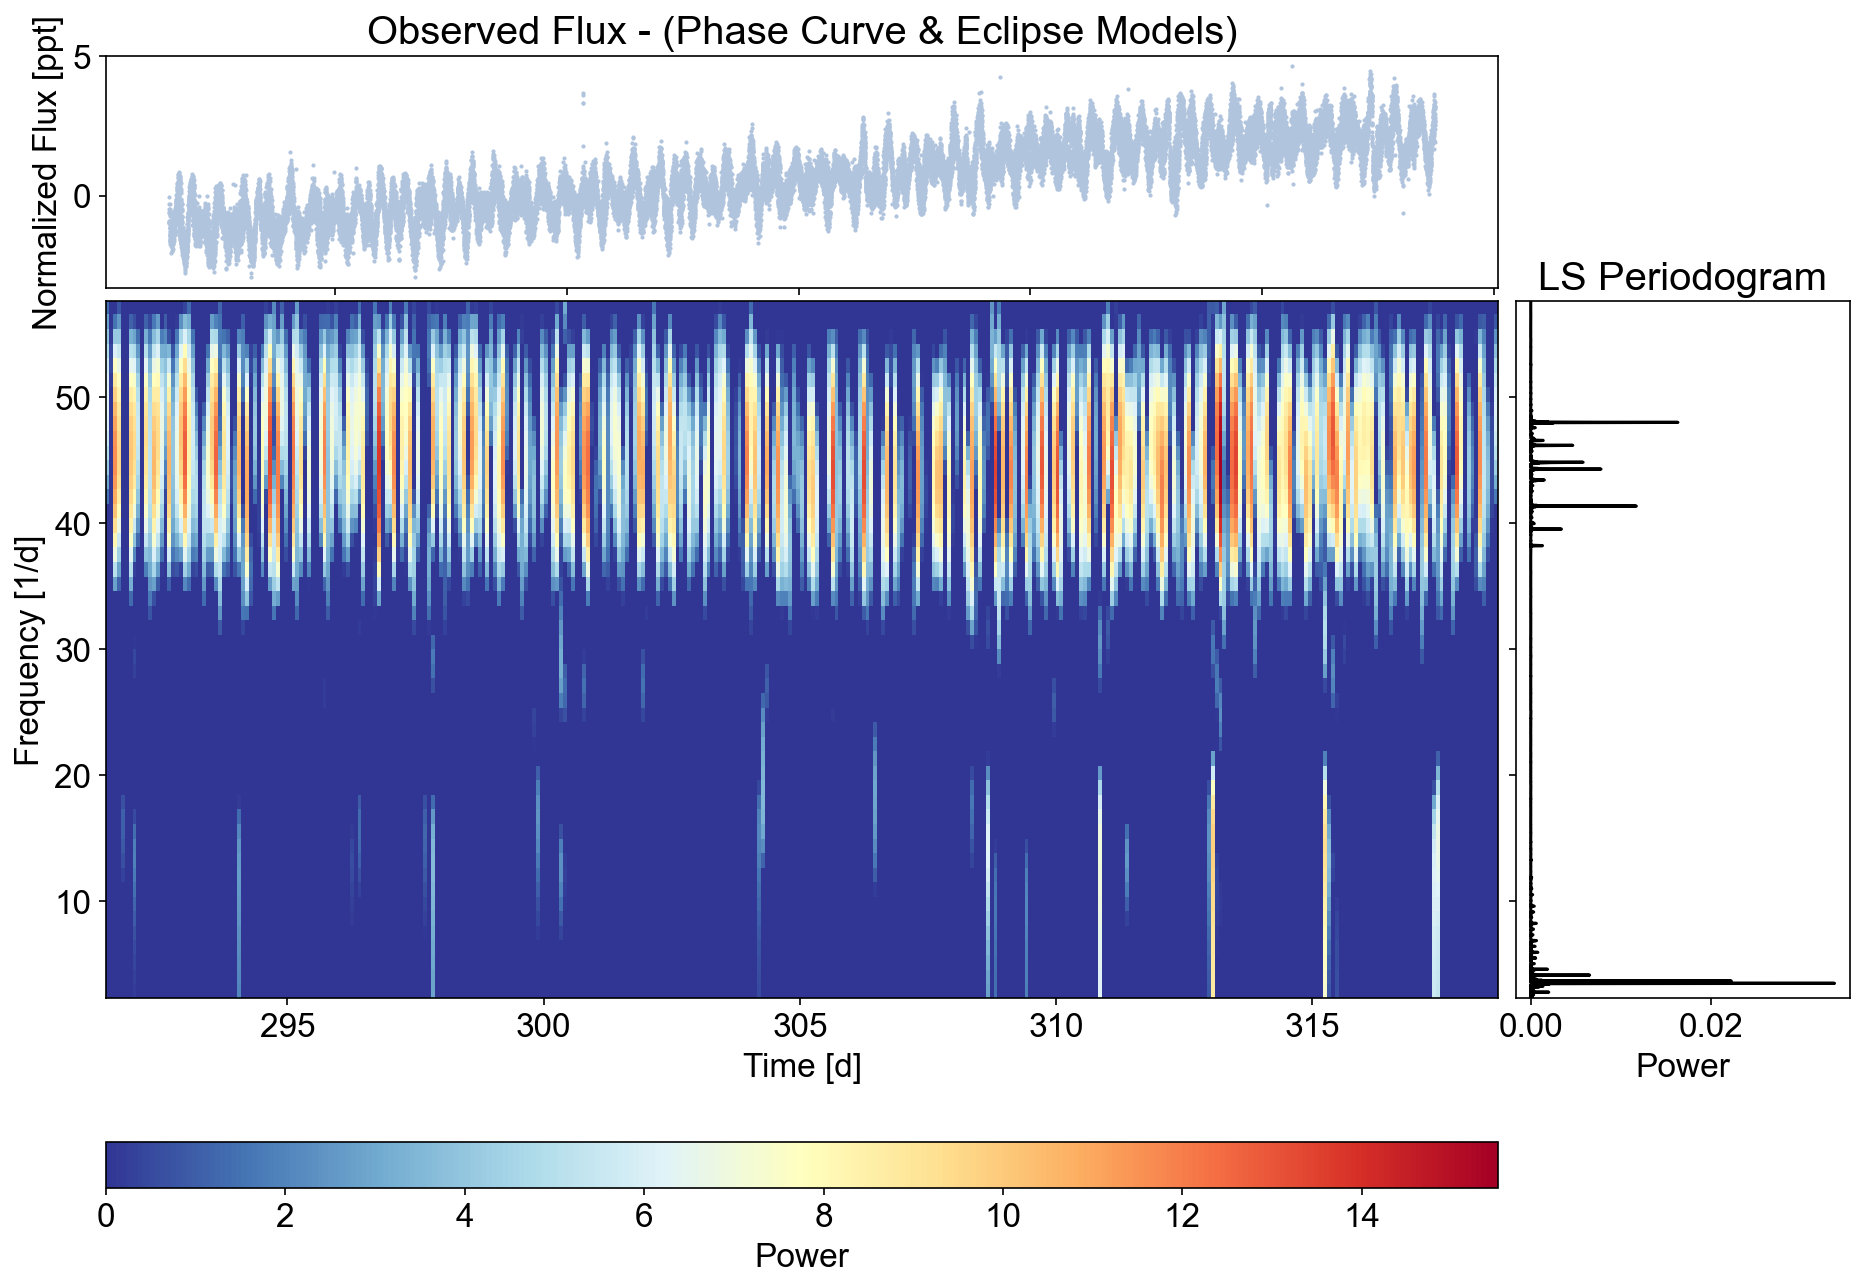

In [581]:
widths = [5, 1.2] # two columns, with widths ratio 6 to 1
heights = [2, 6, 1, .4] # 4 columns:
#   height of top plot, central plot, space for xlabels of central plot and colorbar below
fig, _ = plt.subplots(0, 0, figsize=(15,10))
grid = plt.GridSpec(
    4,
    2,
    hspace=0.05,
    wspace=0.02,
    figure=fig,
    width_ratios=widths,
    height_ratios=heights,
)
# Set up main plot: time vs freq and power as color
ax = fig.add_subplot(grid[1:-2, :-1])

# Set up top plot
ax_top = fig.add_subplot(grid[0, :-1])
ax_top.scatter(x_oot, y_oot, c="lightsteelblue", s=1)  
ax_top.set(ylabel="Normalized Flux [ppt]", title = "Observed Flux - (Phase Curve & Eclipse Models)");


# Set up right plot: freq as y axis hence sharey. NOTE it's inverted wrt the figure above
ax_right = fig.add_subplot(grid[1:-2, -1], sharey=ax)
ax_right.plot(ls_oot["periodogram"][1], ls_oot["periodogram"][0], c="k") 
ax_right.set(xlabel="Power", ylim =(fmin, fmax), title="LS Periodogram");


# Create axes for colorbar below
ax_bottom = fig.add_subplot(grid[-1, :-1])

# Personalize axes
ax_top.tick_params(labelbottom=False)
ax_right.tick_params(labelleft=False)

# main plot
mesh_power = ax.pcolormesh(t2, f2, 10*np.log10(P), vmin=pmin, cmap=color_map)
ax.set(ylabel='Frequency [1/d]', xlabel = 'Time [d]', ylim=(fmin, fmax)) 
fig.colorbar(mesh_power, cax=ax_bottom, label = "Power", orientation="horizontal")

fig.savefig("../figures/tfreq_analysis/spectrogram_view.png")


#ax_right.plot(X * X.conj(), f,  label=r'$|(X)|^2$', c="navy") #unsure about normalization done correctly! y quantity explained here: https://nbviewer.jupyter.org/github/balzer82/FFT-Python/blob/master/FFT-Tutorial.ipynb
#ax_right.set(xlabel="Power", ylim =(fmin-0.5, fmax), xlim=(-0.05,max(yf_norm)));

## Wavelet Analysis

The PyWavelets library for example contains 14 mother Wavelets (families of Wavelets):


In [582]:
import pywt
print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


/Users/mbadenas/opt/anaconda3/envs/mit37_mkl/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


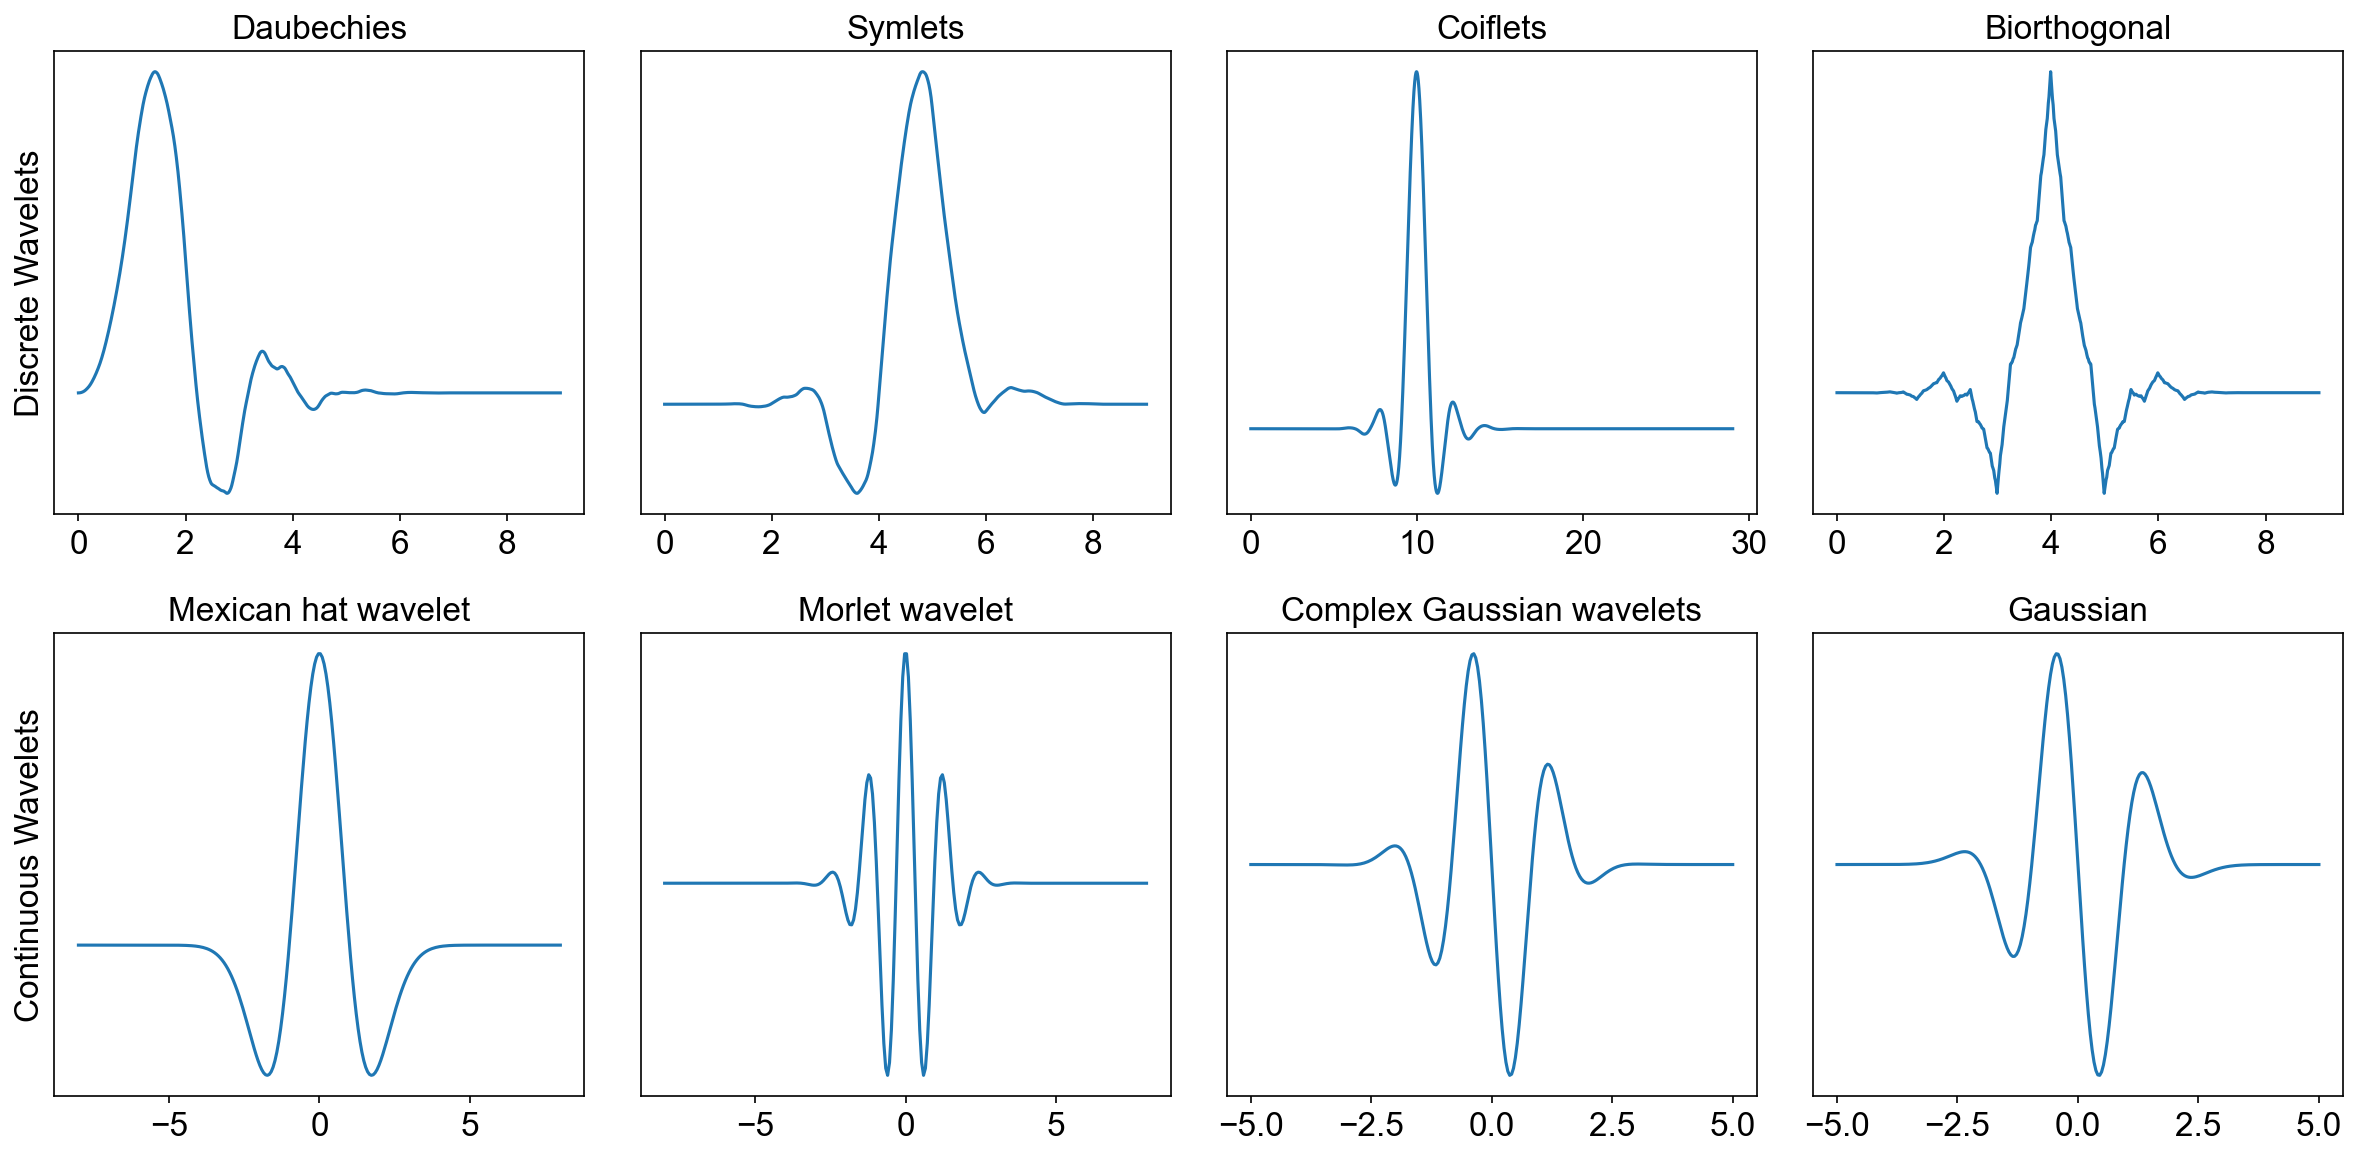

In [30]:
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']

list_list_wavelets = [discrete_wavelets, continuous_wavelets]
list_funcs = [pywt.Wavelet, pywt.ContinuousWavelet]

fig, axarr = plt.subplots(2,4, figsize=(16,8))
for ii, list_wavelets in enumerate(list_list_wavelets):
    func = list_funcs[ii]
    row_no = ii
    for col_no, waveletname in enumerate(list_wavelets):
        wavelet = func(waveletname)
        family_name = wavelet.family_name
        biorthogonal = wavelet.biorthogonal
        orthogonal = wavelet.orthogonal
        symmetry = wavelet.symmetry
        if ii == 0:
            _ = wavelet.wavefun()
            wavelet_function = _[0]
            x_values = _[-1]
        else:
            wavelet_function, x_values = wavelet.wavefun()
        if col_no == 0 and ii == 0:
            axarr[row_no, col_no].set_ylabel("Discrete Wavelets", fontsize=16)
        if col_no == 0 and ii == 1:
            axarr[row_no, col_no].set_ylabel("Continuous Wavelets", fontsize=16)
        axarr[row_no, col_no].set_title("{}".format(family_name), fontsize=16)
        axarr[row_no, col_no].plot(x_values, wavelet_function)
        axarr[row_no, col_no].set_yticks([])
        axarr[row_no, col_no].set_yticklabels([])

plt.tight_layout()
plt.show()

In [31]:
def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.set_xlim(0,60)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = np.fft.fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

40000 70


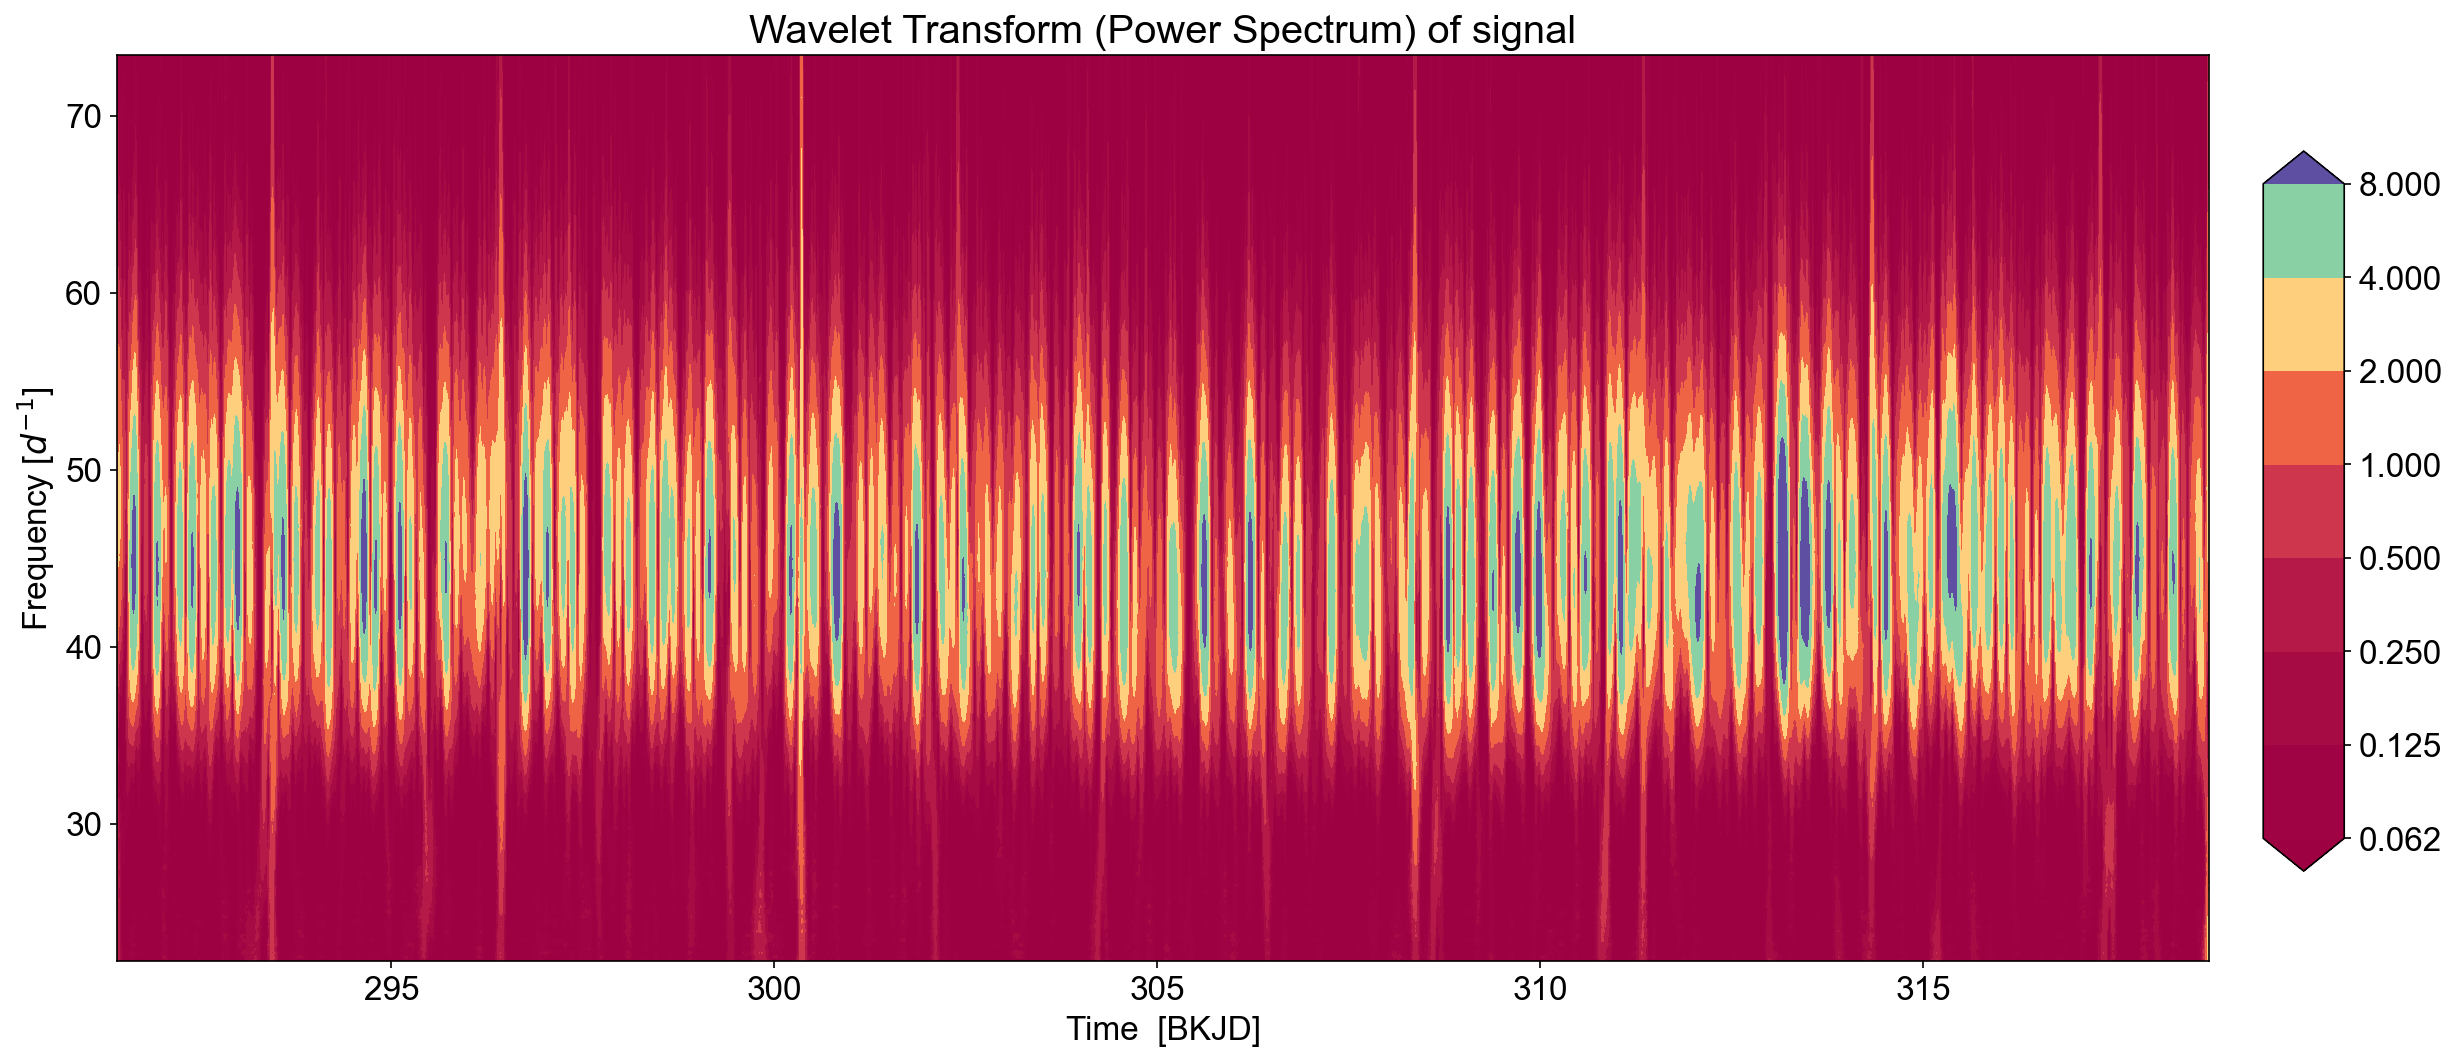

In [130]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor1-1.5', #'cmor0.7-1.5', 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = r'Frequency [$d^{-1}$]', 
                 xlabel = 'Time  [BKJD]'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = levels
    
    fig, ax = plt.subplots(figsize=(18, 8))
    #im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    im = ax.contourf(time, frequencies, power, contourlevels, extend='both',cmap="Spectral")
    
    print(len(time), len(frequencies))
    ax.set(ylabel = ylabel, xlabel = xlabel, title = title) 
    
    #yticks = 2**np.arange(np.ceil(1/period.min())), np.ceil(np.log2(period.max())))
    #ax.set_yticks(np.log2(yticks))
    #ax.set_yticklabels(yticks)
    #ax.invert_yaxis()
    #ylim = ax.get_ylim()
    #ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.92, 0.2, 0.03, 0.6])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    fig.savefig("../figures/wavelets.png")
    plt.show()
    
    return time, frequencies
    
scales = np.arange(30, 100, 1)
#plot_fft_plus_power(x_oot, y_oot)
t_w, f_w = plot_wavelet(x_oot, y_oot, scales)


In [ ]:
def get_scaling_factor(fa, fc):
    "f_a: pseudo-frequency"
    "f_c: central frequency of the Mother wavelet"
    "a : scaling factor"
    a = fc/fa
    return a

In [ ]:
print(get_scaling_factor(fmin, 1.5))
print(get_scaling_factor(fmax, 1.5))

In [ ]:
import scaleogram as scg
wavelet="cmor0.7-1.5"#'cmor1-1.5'
scale = np.arange(1, 100, 1)

wavelets = scg.cws(x_oot, y_oot, scales=scale, wavelet = wavelet, ax=None)

fig, ax = plt.subplots(1,1)
ax.plot(wavelets)

In [ ]:


fig, ax = plt.subplots(1,1)
ax = scg.cws(x_oot, y_oot, 
             scales,
             wavelet = wavelet,
             figsize=(12,6),
             yaxis="frequency",
             ylabel="Frequency [d^-1]", xlabel='Time (BKJD)',
             spectrum = "power")

# Notes on the Fourier Transform and Fast Fourier Transform

## Fourier Transform
The Fourier Transform (FT) of a signal for which only $N$ uniformly sampled values ($g_n \, \forall n \in 0\div N-1$) are available, a.k.a. Discrete Fourier Transform (DFT), is defined as
\begin{equation}
G_k = \sum_{n=0}^{N-1} g_n \exp{\left(-2 \pi i k n / N\right)} \text{,}
\end{equation}
where $k \in \mathbb{N}$ is a point in the frequency domain corresponding to \begin{equation}
f_k = f_s \frac{k}{N} \text{.}
\end{equation}
Thus, the frequency resolution is
\begin{equation}
\Delta f = \frac{f_s}{N} = 2 \frac{f_{max}}{N} \text{.}
\end{equation}
The transform $G_k\equiv G(f_k)$ is periodic every $f_s$ and, if the signal is real, 
$G(f_k) = G^*(-f_k)$, where superscript ${}^*$ indicates conjugate.

One can increase the resolution in frequency (i.e. decrease $\Delta f$) by increasing $N$. If the original signal has no more data points, one can always add extra samples with value $0$. This is, if $N_t$ is the original signal size, and $N_f > N_t$ is such that guarantees the desired $\Delta f$, one just needs to define $g_n = 0 \, \forall n \ge N_t$, and then use $N=N_f$ in the DFT.

In the frequency domain, the typical peak of a sinusoid sampled during a time window of duration $T = (N_t - 1) / f_s$ will be of width $1/T$. If we want to have at least $N_p$ points in the frequency domain on that peak, we will need a $\Delta f = fs / ((N_t - 1) N_p)$. Thus, the desired $N_f$ will be
\begin{equation}
N_f = ((N_t - 1) N_p) \text{.}
\end{equation}

### Fast Fourier Transform
The Fast Fourier Transform, or FFT, is an implementation of thee DFT that works best when $N$ is a power of $2$. Here we compute $G(f_k) \, \forall k \in 0 \div N - 1$ or, equivalently, $\forall k \in - \lfloor N/2 \rfloor \div \lfloor (N-1)/2 \rfloor$

In [ ]:
Nf = N_samples_per_peak * (Nt - 1) # Minimum required nº of frequency points
print('Minimum nº of frequency samples needed for %i points per peak: %d' %(N_samples_per_peak, Nf))

In [ ]:
Nf = int(2**np.ceil(np.log2(Nf))) # Closest power of 2 above Nf
print("Number of frequency samples: 2^{:d} = {:d},".format(int(np.log2(Nf)),Nf))
print("    which shall give a frequency step of {:g} Hz (desired {:g} Hz)"
     .format(fs/Nf, 1/(N_samples_per_peak * T)))

In [ ]:
X = np.fft.fft(y_oot, Nf)
f = np.fft.fftfreq(Nf,dt) # frequency as fs k/N for k = 0:N-1
f, X = map(np.fft.fftshift,(f,X)) # frequency as fs k/N for k = -N//2:(N-1)//2

In [ ]:
print('Indeed, output step step is {:g} Hz'.format(f[1]-f[0]))
plt.plot(f, X.real, label=r'$\mathbb{R}(X)$')
plt.plot(f, X.imag, label=r'$\mathbb{I}(X)$')
plt.legend()

When the signal is real, as is the case, the positive part of the $G(f_k)$ is equal to the conjugate of the negative part. In such cases, one can use the rfft function, which takes advantage of this property and only computes $G(f_k) \, \forall k \in 0 \div \lfloor N/2\rfloor$.

In [ ]:
X = np.fft.rfft(y_oot, Nf)
f = np.fft.rfftfreq(Nf,dt) # frequency as fs k/N for k = 0:N//2+1
print('Again, output frequency step is {:g} Hz'.format(f[1]-f[0]))
plt.plot(f, X.real, label=r'$\mathbb{R}(X)$')
plt.plot(f, X.imag, label=r'$\mathbb{I}(X)$')
plt.legend()
plt.xlim(-0.5,60)

Periodogram

In [ ]:
plt.plot(f, X * X.conj(), label=r'$|(X)|^2$')
plt.legend()
plt.xlim(0,60)

## Spectrogram
The spectrogram shares the same frequency resolution characteristics as the rfft, with the additional fact that now time resolution has to be taken into account, too.

* Too high time resolution (low $\Delta t_2$) will result in fuzziness along the frequency direction 
* Too low time resolution (high $\Delta t_2$) will result in the inability to capture frequencies changing too fast over time 
* A trade off time resolution will give a well focused spectrogram with able to detect frequencies that change over time 

In [ ]:
dt2 = 0.16 # Desired time resolution (warning, too low dt2 will result in a lot of noise)

In [ ]:
overlap = 1/8
Nt_chunk = dt2 / dt / (1 - overlap) # maximum number of samples per chunk with 1/8 overlap, if dt2 is to be respected
Nt_chunk = max(int(2**np.floor(np.log2(Nt_chunk))), 2) # closer power of two below maximum

print("Number of samples per chunk: {:d},".format(Nt_chunk))
print("    which shall give a time resolution of {:g} d (desired {:g} d)"
     .format((Nt_chunk - Nt_chunk//8)*dt, dt2))

In [ ]:
Tseg = dt * (Nt_chunk - 1) # Duration of one chunk

print("Each chunk, then, will last {:g} d".format(Tseg))
print("    which will result in an effective frequency resolution of {:g} d^-1"
      .format(1/Tseg))

In [ ]:
Nf = N_samples_per_peak * (Nt_chunk - 1) # Minimum required number of frequency points
print('Minimum number of frequency samples needed for {:d} points per peak: {:d}'
      .format(N_samples_per_peak, Nf))

In [ ]:
Nf = int(2**np.ceil(np.log2(Nf))) # Closest power of 2 above Nf

print("Number of frequency samples = 2^{:d} = {:d},".format(int(np.log2(Nf)),Nf))
print("    which shall give a frequency step of {:g} d^-1 (desired {:g} d^-1)"
     .format(fs/Nf, fs/(N_samples_per_peak * (Nt_chunk - 1))))

In [ ]:
f, t2, Pxx = spectrogram(y_oot, fs, nperseg=Nt_chunk, nfft=Nf)
 
print('Again, output frequency step is {:g} d^-1'.format(f[1]-f[0]))
print('Furthermore, output time resolution is {:g} d'.format(t2[1]-t2[0]))

fig = plt.figure(figsize=(18,8))
fig.subplots_adjust(wspace=0.0)
ax1 = fig.add_subplot(121) 
ax2 = fig.add_subplot(122, projection='3d')

mesh_power = ax1.pcolormesh(t2, f,  10*np.log10(Pxx), cmap="Blues")
ax1.set(ylabel='Frequency [1/d]', xlabel = 'Time [d]', ylim=(min(freq_grid), 1.2*max(osc_data["freq"])));
fig.colorbar(mesh_power, ax=ax1, label = "Power")

ax2.plot_surface(f[:, None], t2[None, :], 10.0*np.log10(Pxx), cmap="Blues");
ax2.set_xlabel("Frequency (1/d)",labelpad = 25)
ax2.set_ylabel("Time (d)",labelpad = 25);
ax2.set_zlabel("Power",labelpad = 10);

In [ ]:
import sounddevice as sd
sd.play(y_oot, fs)

In [ ]:
1/15